In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import VECM
import itertools
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Primero importamos los datos

In [0]:
url='https://raw.githubusercontent.com/HiperMaximus/Deteccion-de-eventos-climaticos-anormales-multivariados/master/Data/Bucaros.csv'
data = pd.read_csv(url)
data['time']=pd.to_datetime(data['time'])

In [3]:
#Ponemos el indice apropiado
data.set_index(keys='time',inplace=True)
data.head()

,air_temperature_2m,black_sky_albedo,black_sky_albedo_avhrr,cee,cer,cfc,cot,cph,cth,ctp,ctt,fapar_tip,gross_primary_productivity,iwp,latent_energy,leaf_area_index,lwp,max_air_temperature_2m,min_air_temperature_2m,net_ecosystem_exchange,net_radiation,par,precipitation,precipitation_era5,sensible_heat,stemp,terrestrial_ecosystem_respiration,white_sky_albedo,white_sky_albedo_avhrr
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-05,294.30330,0.054231,0.148113,0.733573,12.858556,0.545806,6.721392,0.757114,5.004890,600.8233,272.05685,0.200402,5.472836,49.609653,10.137719,0.659604,49.399300,300.07846,289.41510,-0.980396,12.967238,104.994286,3.587027,0.084811,2.512422,295.07290,4.054601,0.063236,0.152386
2001-01-13,294.06393,0.054701,0.143245,0.733573,12.858556,0.545806,6.721392,0.757114,5.004890,600.8233,272.05685,0.193618,5.254573,49.609653,9.506692,0.636765,49.399300,299.31683,290.27124,-0.834613,12.333978,97.485720,3.185243,0.110481,2.499584,295.07290,4.042849,0.065022,0.146898
2001-01-21,293.84207,0.053148,0.135720,0.733573,12.858556,0.545806,6.721392,0.757114,5.004890,600.8233,272.05685,0.227760,4.896469,49.609653,9.094871,0.550402,49.399300,298.91852,290.10000,-0.826002,11.751306,88.011430,7.270531,0.150449,2.340233,295.07290,3.817642,0.064651,0.138990
2001-01-29,293.66687,0.052384,0.128042,0.737401,12.954879,0.535922,6.395939,0.754567,5.111065,593.0472,271.52954,0.314410,5.263164,47.776234,10.573850,0.797828,46.766113,298.97195,286.45930,-0.967613,14.153911,122.514280,0.004196,0.068781,3.515094,295.09152,3.965203,0.065440,0.128025
2001-02-06,294.09616,0.053631,0.124199,0.764197,13.629138,0.466735,4.117774,0.736735,5.854290,538.6146,267.83844,0.355382,5.009530,34.942320,10.368669,0.974908,28.333838,300.06467,288.10977,-0.814792,14.031088,120.320000,0.024482,0.085648,3.504910,295.22190,3.886791,0.068387,0.125026


Ahora realizamos los plots de las series de tiempo que probablemente tengan relación

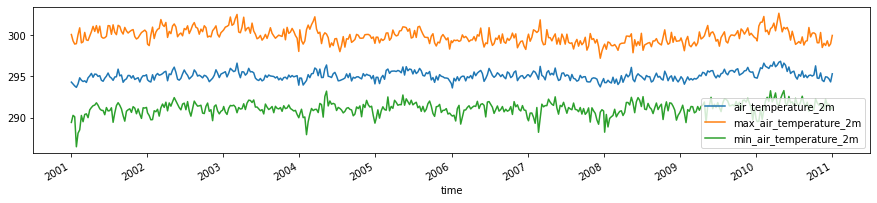

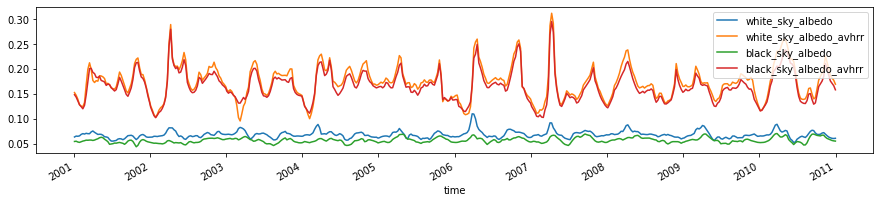

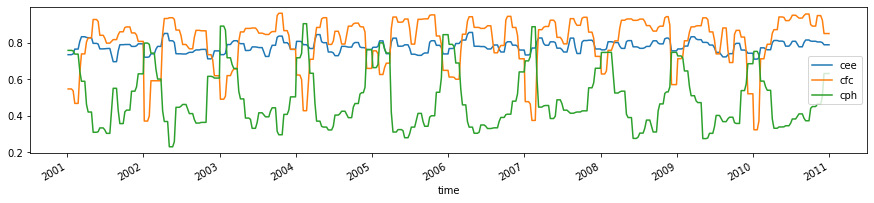

In [4]:
ax = plt.gca()
data[['air_temperature_2m','max_air_temperature_2m','min_air_temperature_2m']].plot(figsize=(15, 3),ax=ax)
data[['white_sky_albedo','white_sky_albedo_avhrr','black_sky_albedo','black_sky_albedo_avhrr']].plot(figsize=(15, 3))
data[['cee','cfc','cph']].plot(figsize=(15, 3))
plt.show()

Observamos que hay una fuerte correlación que puede no ser necesariamente lineal. Esto nos indica reducción de dimensionalidad con Kernel PCA. Además, para asegurarnos que las subsecuentes series de tiempo no estén cointegradas (ni integradas) y podamos usar VARMAX, realizaremos el Johansen test. Este test ha sido implementado en Python hasta un maximo de 12 series de tiempo a la vez, por lo que usaremos 12 como el numero de componentes para el KPCA

In [5]:
#Preparamos los datos y transformamos
scaler=StandardScaler()
X_standard=scaler.fit_transform(data)
transformer = KernelPCA(n_components=12, kernel='rbf',fit_inverse_transform=True)
X_transformed = transformer.fit_transform(X_standard)
Kdf=pd.DataFrame([])
for n in range(12):
  Kdf['component_'+str(n)]=X_transformed[:,n]
Kdf.set_index(pd.to_datetime(data.index),inplace=True)
Kdf.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11
time,,,,,,,,,,,,
2001-01-05,-0.421833,-0.404513,-0.164211,0.027958,0.201836,-0.064158,-0.054957,0.260761,-0.030148,-0.112002,0.071837,0.085481
2001-01-13,-0.490470,-0.315579,-0.258081,0.004340,0.133290,-0.083813,-0.034212,0.175509,0.121046,-0.171459,0.135888,0.124266
2001-01-21,-0.469878,-0.193964,-0.152518,-0.086377,0.016416,-0.153098,-0.112728,0.029321,0.186500,-0.168983,0.205104,0.091204
2001-01-29,-0.248870,-0.241187,0.206794,-0.090959,0.087885,-0.088223,-0.232563,0.150276,-0.015006,0.048526,-0.062341,0.047057
2001-02-06,-0.263593,-0.292825,0.198774,-0.095649,0.146220,0.013947,-0.292738,0.157897,0.011607,0.062250,-0.055001,0.095657


In [0]:
def cointegration_test(df,detOrder=0,laggDiff =0,tabletype='plain'):
  test=coint_johansen(df, detOrder, laggDiff)

  crits=test.cvt
  trSt=test.lr1
  table=[['rank',' ','Trace statistic','Crit 90%','Crit 95%','Crit 99%']]
  for i,cvt in enumerate(crits):
    table.append(['r<='+str(i),'variable '+str(i),trSt[i]])
    for val in cvt:
      table[i+1].append(val)
  table.append([' ',' ',' ',' ', '',' '])
  tableSt=np.array(table)

  crits=test.cvm
  trSt=test.lr2
  table=[['rank',' ','Max eigenvalue statistic','Crit 90%','Crit 95%','Crit 99%']]
  for i,cvt in enumerate(crits):
    table.append(['r<='+str(i),'variable '+str(i),trSt[i]])
    for val in cvt:
      table[i+1].append(val)
  tableEt=np.array(table)
  table=np.vstack((tableSt,tableEt))
  table=tabulate(table, tablefmt=tabletype)
  return test,table

In [7]:
test,table=cointegration_test(Kdf,laggDiff=0)
print(table)

rank                Trace statistic           Crit 90%  Crit 95%  Crit 99%
r<=0   variable 0   1531.4778595345604        326.5354  334.9795  351.215
r<=1   variable 1   1188.2095890922992        277.374   285.1402  300.2821
r<=2   variable 2   925.1166427309361         232.103   239.2468  253.2526
r<=3   variable 3   709.8414920364875         190.8714  197.3772  210.0366
r<=4   variable 4   543.3816779944981         153.6341  159.529   171.0905
r<=5   variable 5   405.51239123399034        120.3673  125.6185  135.9825
r<=6   variable 6   296.6121118384327         91.109    95.7542   104.9637
r<=7   variable 7   216.0903906466637         65.8202   69.8189   77.8202
r<=8   variable 8   152.4817823484261         44.4929   47.8545   54.6815
r<=9   variable 9   93.91100361900867         27.0669   29.7961   35.4628
r<=10  variable 10  51.12475742965885         13.4294   15.4943   19.9349
r<=11  variable 11  18.56356990370095         2.7055    3.8415    6.6349

rank                Max eigenva

In [8]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(Kdf)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
component_0 ::  759.59    > 311.1288  =>   True
component_1 ::  619.71    > 263.2603  =>   True
component_2 ::  507.26    > 219.4051  =>   True
component_3 ::  416.23    > 179.5199  =>   True
component_4 ::  331.95    > 143.6691  =>   True
component_5 ::  252.14    > 111.7797  =>   True
component_6 ::  199.6     > 83.9383   =>   True
component_7 ::  149.67    > 60.0627   =>   True
component_8 ::  104.25    > 40.1749   =>   True
component_9 ::  67.06     > 24.2761   =>   True
component_10 ::  38.45     > 12.3212   =>   True
component_11 ::  14.3      > 4.1296    =>   True


Podemos concluir que la serie no presenta cointegración (y por lo tanto tampoco integración). Veamos esto graficamente:

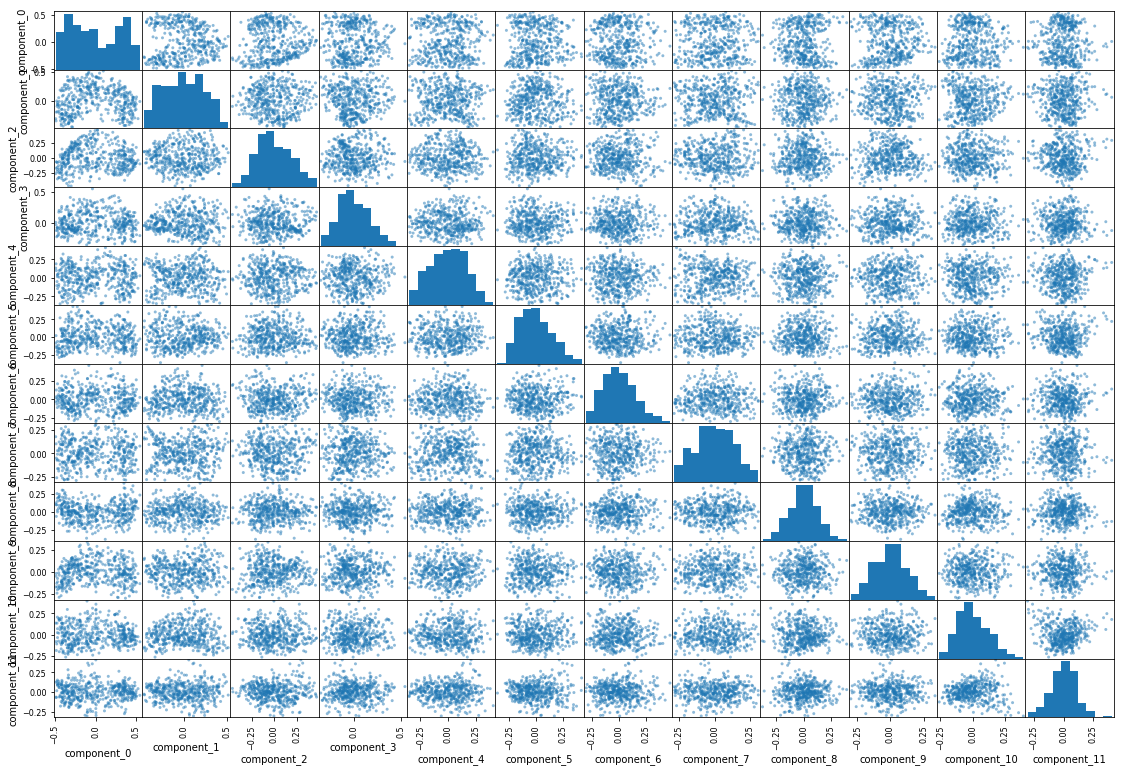

In [9]:
axes=pd.plotting.scatter_matrix(Kdf, figsize=(19,13));

Ahora hagamos los plots de los componentes

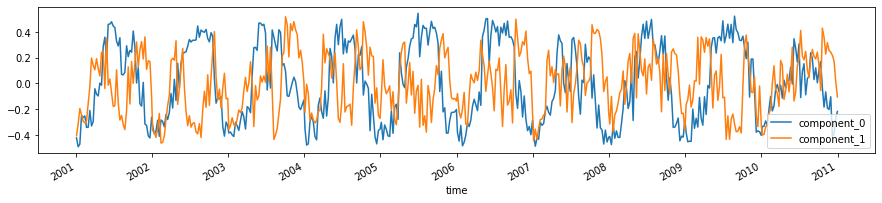

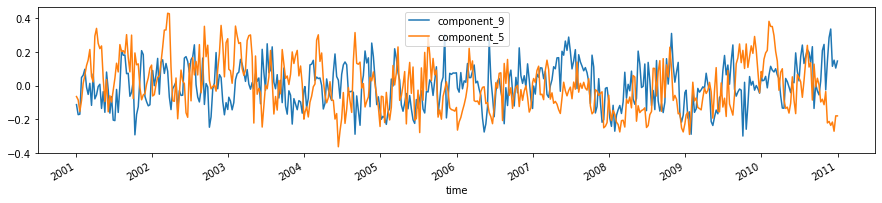

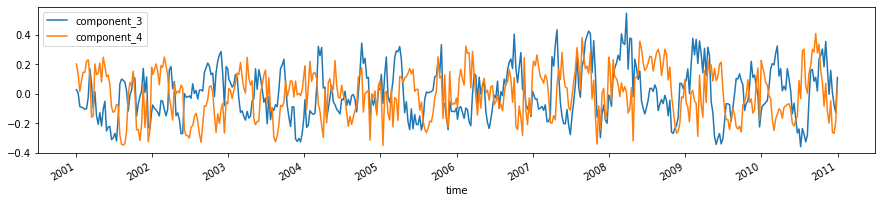

In [13]:
ax = plt.gca()
Kdf[['component_0','component_1']].plot(figsize=(15, 3), ax=ax)
Kdf[['component_9','component_5']].plot(figsize=(15, 3))
Kdf[['component_3','component_4']].plot(figsize=(15, 3))

Ahora realizemos el test de estacionariedad y veamos el comportamiento en el tiempo de la media y desviación estandar

In [0]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
#Plot rolling statistics:
    plt.figure(figsize=(15,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    ## Prueba de Dickey-fuller: esta es una de las pruebas estadísticas para verificar la estacionariedad. 
    #Primero consideramos la hipótesis nula: la serie temporal no es estacionaria. 
    #El resultado del resto contendrá la estadística de prueba y el valor crítico para diferentes niveles de 
    #confianza. La idea es tener estadísticas de prueba inferiores al valor crítico, en este caso podemos rechazar 
    #la hipótesis nula y decir que esta serie de tiempo es estacionaria
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

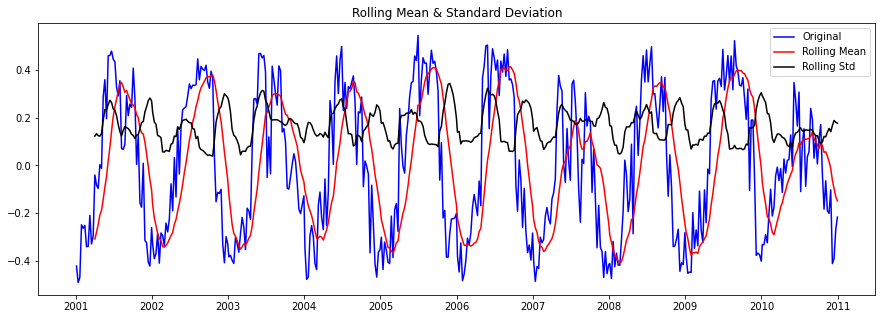

Results of Dickey-Fuller Test:
Test Statistic                -9.493800e+00
p-value                        3.593660e-16
#Lags Used                     1.800000e+01
Number of Observations Used    4.410000e+02
Critical Value (1%)           -3.445266e+00
Critical Value (5%)           -2.868116e+00
Critical Value (10%)          -2.570273e+00
dtype: float64


In [15]:
test_stationarity(Kdf['component_0'])

Vemos que el test de Dickey-Fuller nos dice que la serie es estacionaria aunque visiblemente tiene por lo menos un componente estacional con periodo de un año (52 semanas); esto implica que la serie es ciclica. Ahora debemos eliminar estas frecuencias que dominan la serie de tiempo

## Descomposición estacional

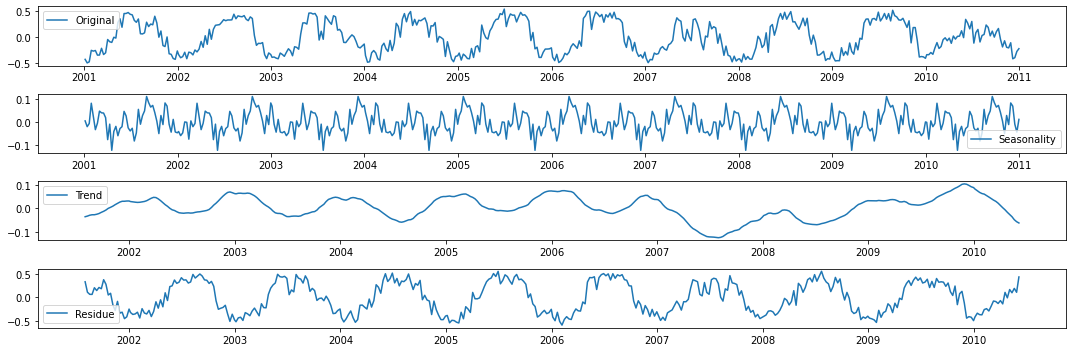

In [16]:
decomposition = seasonal_decompose(Kdf['component_0'],freq=52)
seasonal = decomposition.seasonal
trend=decomposition.trend
residue=decomposition.resid
plt.figure(figsize=(15,5))
plt.subplot(411)
plt.plot(Kdf['component_0'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residue, label='Residue')
plt.legend(loc='best')
plt.tight_layout()


Vemos que incluso eliminando esta frecuencia principal se observa estacionalidad en el residuo, por lo que debemos transformar la serie al espacio de frecuencias y eliminar las dominantes. Para esto usaremos analisis de Fourier

In [0]:
def filterSeasonalityFourier(X,factor=3.5):
  fourierCoef=np.fft.rfft(X,axis=0)
  fourCoefReal=np.abs(fourierCoef)
  shape=np.shape(fourierCoef)
  fCRmeans=np.mean(fourCoefReal,axis=0)
  fCRmeans=np.tile(fCRmeans,(shape[0],1))

  fCRstd=np.std(fourCoefReal,axis=0)
  fCRstd=np.tile(fCRstd,(shape[0],1))

  sel=(fourCoefReal-fCRmeans>factor*fCRstd)
  fourierCoef[sel]=0
  TS=np.fft.irfft(fourierCoef,axis=0)
  return np.abs(TS),sel,fourierCoef,np.shape(X)

In [0]:
filteredData,sel,fourierCoef,shape_Kdf=filterSeasonalityFourier(Kdf)
Fdf=Kdf.copy()
for i,name in enumerate(Fdf.columns):
  Fdf[name]=filteredData[:,i]

#Fdf=Kdf.copy()

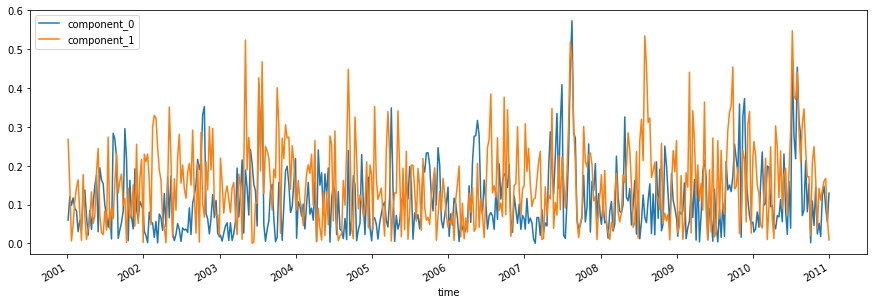

In [19]:
Fdf[['component_0','component_1']].plot(figsize=(15, 5))

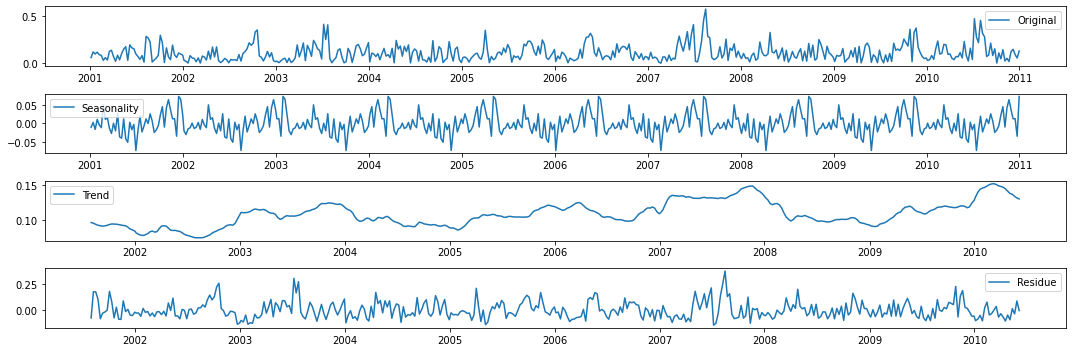

In [20]:
decomposition = seasonal_decompose(Fdf['component_0'],freq=52)
seasonal = decomposition.seasonal
trend=decomposition.trend
residue=decomposition.resid
plt.figure(figsize=(15,5))
plt.subplot(411)
plt.plot(Fdf['component_0'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residue, label='Residue')
plt.legend(loc='best')
plt.tight_layout()

Podemos observar que el comportamiento de la serie ya no tiene un componente estacional fuerte, por lo que podemos seguir. 
El siguiente paso es realizar el test de Dickey-Fuller para cada una de las series y revisar que todas sean estacionarias

In [0]:
def adfullerSystematic(df,auto_lag='AIC',tabletype='plain'):
  cols=['Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Value 1%','Critical Value 5%','Critical Value 10%' ]
  indx=list(df.columns)

  results =[adfuller(df[column], autolag=auto_lag) for column in indx]
  rows=[]
  
  for res in results:
    critVals=[value for key,value in res[4].items()]
    row=list(res[:4])+critVals
    row=np.array(row)
    rows.append(row)
  fullerDf=pd.DataFrame(rows,columns=cols,index=indx)

  return fullerDf

In [22]:
fullerDf=adfullerSystematic(Fdf)
fullerDf

,Test Statistic,p-value,#Lags Used,Number of Observations Used,Critical Value 1%,Critical Value 5%,Critical Value 10%
component_0,-10.487892,1.167432e-18,1.0,458.0,-3.444709,-2.867871,-2.570142
component_1,-6.456621,1.477973e-08,6.0,453.0,-3.444868,-2.867941,-2.570180
component_2,-9.458593,4.415993e-16,3.0,456.0,-3.444772,-2.867899,-2.570157
component_3,-8.511103,1.166862e-13,2.0,457.0,-3.444740,-2.867885,-2.570150
component_4,-14.794490,2.146007e-27,0.0,459.0,-3.444677,-2.867857,-2.570135
component_5,-11.780549,1.037385e-21,1.0,458.0,-3.444709,-2.867871,-2.570142
component_6,-11.632936,2.239870e-21,1.0,458.0,-3.444709,-2.867871,-2.570142
component_7,-18.753645,2.027295e-30,0.0,459.0,-3.444677,-2.867857,-2.570135
component_8,-9.763379,7.459966e-17,3.0,456.0,-3.444772,-2.867899,-2.570157
component_9,-10.495796,1.116443e-18,2.0,457.0,-3.444740,-2.867885,-2.570150


Podemos ver que todas las series de tiempo son estacionarias. Ahora probemos que las series no tengan causalidad predictiva

In [0]:
#Granger Causality Test
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False,maxlag=5):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [24]:
grangers_causation_matrix(Fdf, variables = Fdf.columns)
#grangers_causation_matrix(Kdf, variables = Fdf.columns)

,component_0_x,component_1_x,component_2_x,component_3_x,component_4_x,component_5_x,component_6_x,component_7_x,component_8_x,component_9_x,component_10_x,component_11_x
component_0_y,1.0000,0.0203,0.2560,0.3100,0.1671,0.1029,0.3602,0.4147,0.0339,0.0038,0.3929,0.3718
component_1_y,0.4120,1.0000,0.7079,0.1972,0.1368,0.0407,0.3608,0.1968,0.2856,0.3375,0.4300,0.1328
component_2_y,0.3843,0.6133,1.0000,0.1206,0.3135,0.5860,0.1093,0.0749,0.1299,0.0009,0.0602,0.2258
component_3_y,0.0731,0.1826,0.7587,1.0000,0.3737,0.3963,0.5349,0.2069,0.1061,0.0810,0.0158,0.4564
component_4_y,0.2893,0.2936,0.3594,0.2922,1.0000,0.0374,0.4924,0.0955,0.3807,0.7673,0.1205,0.0761
component_5_y,0.1868,0.1942,0.7138,0.8286,0.0031,1.0000,0.4270,0.3773,0.4674,0.4082,0.1260,0.0358
component_6_y,0.0519,0.4487,0.7402,0.1145,0.0018,0.1237,1.0000,0.0412,0.3038,0.3328,0.2406,0.5363
component_7_y,0.4310,0.0047,0.1051,0.0618,0.1399,0.2533,0.5502,1.0000,0.2798,0.5884,0.0468,0.1689
component_8_y,0.1065,0.5545,0.7321,0.2721,0.5843,0.0167,0.0559,0.1077,1.0000,0.6455,0.5455,0.2509
component_9_y,0.0223,0.0207,0.0913,0.3117,0.0319,0.0059,0.2940,0.1321,0.0052,1.0000,0.2970,0.2680


Podemos observar que la causalidad predictiva es minima, por lo que podemos continuar.

Ahora que hemos revisado todas las presuposiciones que requiere el modelo podemos realizar el fitting sobre VARIMAX

## Varmax

ACF & PACF

Ahora estimemos los mejors parametros de AR y MA. Para esto estimamos la Autocorrelation Function y Partial Autocorrelation Function de cada serie de tiempo y de acá extraemos el espacio de busqueda para hacer gridsearch

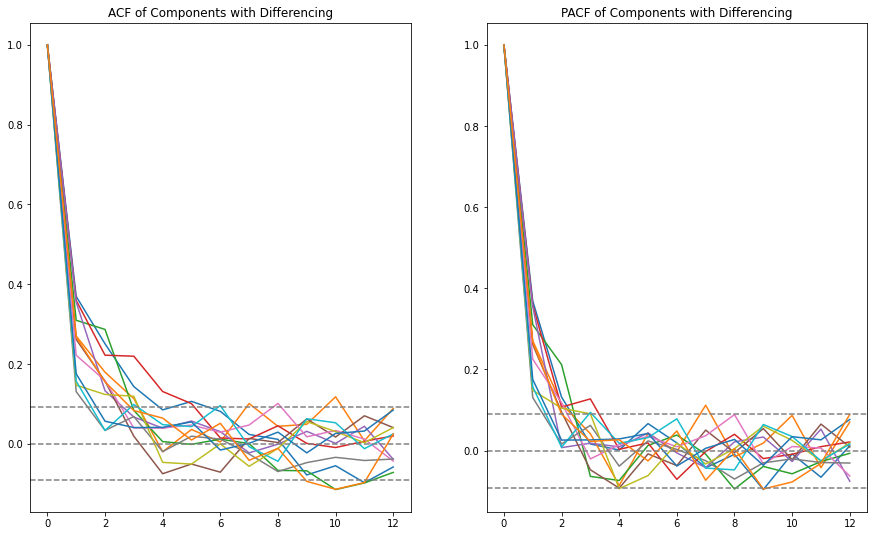

In [25]:
#ACF & PACF
cols=list(Fdf.columns)

lags = 12

lags_acf=[acf(Fdf[name].values, nlags = lags) for name in cols]
lags_pacf=[pacf(Fdf[name].values, nlags = lags, method='ols') for name in cols]

#Plots

plt.figure(figsize=(15, 9))

plt.subplot(1, 2, 1)
for lAcf in lags_acf:
  plt.plot(lAcf)

plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Fdf)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(Fdf)), linestyle='--', color='gray')
plt.title('ACF of Components with Differencing')

plt.subplot(1, 2, 2)
for lPacf in lags_pacf:
  plt.plot(lPacf)

plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Fdf)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(Fdf)), linestyle='--', color='gray')
plt.title('PACF of Components with Differencing')
            
plt.show()

Podemos ver que el espacio de busqueda para AR (p) es de [0,3] y MA (q) es de [0,2], puesto que casi todas las series cruzan el treshold para estos valores.

In [0]:
def AR_MA_gridsearch(X,y,searchSpace):
  min_mse=np.inf
  for pq in searchSpace:
    model=VARMAX(X, order=pq)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast(nobs)
    mse=mean_squared_error(y,yhat)
    if mse<min_mse:
      min_mse=mse
      best_order=pq
      best_model=model_fit
    return best_order,min_mse,best_model

In [0]:
#train y test
nobs = 80
Fdf_train, Fdf_test = Fdf[0:-nobs], Fdf[-nobs:]

In [28]:
#search space
pSpace=range(9)
qSpace=range(5)
searchSpace=list(itertools.product(pSpace,qSpace))[1:]#(0,0) no hace parte del espacio de busqueda
#gridsearch
order,mse,model=AR_MA_gridsearch(Fdf_train,Fdf_test,searchSpace)
print('El mejor orden para el modelo es: '+str(order)+', con un MSE de: '+str(mse))

El mejor orden para el modelo es: (0, 1), con un MSE de: 0.006690975638503093


Ahora tenemos el modelo y conocemos el orden optimo del modelo: (0,1)

Por ultimo evaluemos si hemos logrado captar toda la información útil para realizar forecasts de los residuos. Para esto vamos a realizar el siguiente test:

Durbin Watson Statistic - Serial Correlation of Residuals

In [29]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model.resid)

def adjust(val, length = 6): return str(val).ljust(length)

for col, val in zip(Fdf.columns, out):
    print(adjust(col), ':', round(val, 2))

component_0 : 1.91
component_1 : 1.93
component_2 : 1.9
component_3 : 1.91
component_4 : 1.9
component_5 : 1.96
component_6 : 1.93
component_7 : 2.02
component_8 : 1.98
component_9 : 2.0
component_10 : 1.96
component_11 : 1.89


Todos los valores son cercanos a 2, por lo que podemos concluir que no hay correlación significativa en los residuos

Forecasting and visualization

Primero debemos invertir las transformaciones

In [0]:
def invTransform(forecast,Scaler_model,KPCA_model,sel_fourier,fourierCoef,shape_Kdf):
  #Inverse fourier
  shapeOgf=np.shape(np.fft.irfft(fourierCoef,n=shape_Kdf[0],axis=0))
  colsTr=np.shape(forecast)

  shapeBed_0s=(shapeOgf[0]-colsTr[0],shapeOgf[1])
  zerosBed=np.zeros(shapeBed_0s)

  tFcshape=np.shape(np.fft.rfft(forecast,axis=0))
  forecast=np.vstack((forecast,zerosBed))

  transformedFourierCoef=np.fft.rfft(forecast,axis=0)
  fourierCoefShape=np.shape(fourierCoef)
  transformedFourierCoef[colsTr[0]:]=fourierCoef[colsTr[0]:]*(tFcshape[0]/fourierCoefShape[0])
  transformedFourierCoef[sel_fourier]=fourierCoef[sel_fourier]

  Kdf=np.abs(np.fft.irfft(transformedFourierCoef,axis=0))
  Kdf=Kdf[:colsTr[0]]
  #Inverse KPCA
  X_standard=KPCA_model.inverse_transform(Kdf)
  X=Scaler_model.inverse_transform(X_standard)

  return X


In [31]:
forecast=model.forecast(nobs)
TsForecast=invTransform(forecast,scaler,transformer,sel,fourierCoef,shape_Kdf)
X_standard=transformer.inverse_transform(Kdf)
X=scaler.inverse_transform(X_standard)
indx=pd.to_datetime(list(Fdf_test.index))
cols=list(data.columns)
forecastDf=pd.DataFrame(TsForecast,index=indx,columns=cols)
forecastDf.head()

,air_temperature_2m,black_sky_albedo,black_sky_albedo_avhrr,cee,cer,cfc,cot,cph,cth,ctp,ctt,fapar_tip,gross_primary_productivity,iwp,latent_energy,leaf_area_index,lwp,max_air_temperature_2m,min_air_temperature_2m,net_ecosystem_exchange,net_radiation,par,precipitation,precipitation_era5,sensible_heat,stemp,terrestrial_ecosystem_respiration,white_sky_albedo,white_sky_albedo_avhrr
2009-04-11,295.170154,0.058724,0.173848,0.784571,18.014574,0.831184,6.554667,0.456829,7.356599,467.095760,258.402340,0.162215,5.447280,110.253123,9.486943,0.455006,47.856521,299.983212,291.269076,-0.923824,12.902530,100.059190,2.971350,0.243431,2.508643,295.830934,4.160923,0.070692,0.182426
2009-04-19,295.240325,0.059980,0.178058,0.787984,18.187665,0.855997,6.419733,0.436205,7.514122,458.626036,257.469785,0.159894,5.448788,104.027083,9.423102,0.481706,47.102330,300.025099,291.463222,-0.920697,12.839595,99.294987,3.181364,0.260326,2.470418,295.884422,4.165909,0.071732,0.186908
2009-04-27,295.277603,0.060604,0.180569,0.790624,18.407286,0.874986,6.340014,0.419365,7.644925,451.563831,256.671780,0.157465,5.458613,102.689415,9.384806,0.490789,46.688072,300.046680,291.580263,-0.923759,12.802029,98.716826,3.614971,0.268978,2.442628,295.904102,4.170091,0.072162,0.189623
2009-05-05,295.322146,0.060479,0.181865,0.791326,18.648937,0.875552,6.460363,0.410319,7.726859,447.015727,256.178438,0.157246,5.510809,109.041318,9.480753,0.486076,47.457469,300.112623,291.568523,-0.937398,12.968040,100.451955,3.566482,0.270127,2.491721,295.955090,4.193955,0.072414,0.191140
2009-05-13,295.288676,0.060123,0.179865,0.788897,18.388750,0.864364,6.440851,0.423872,7.615170,453.109380,256.858547,0.156061,5.497697,106.384104,9.482944,0.470515,47.321689,300.072546,291.508224,-0.934992,12.943422,100.203980,3.382603,0.263423,2.492190,295.926145,4.185401,0.071937,0.189076


In [0]:
forecastDf_scal=StandardScaler().fit_transform(forecastDf)
forecastDf=pd.DataFrame(forecastDf_scal,index=indx,columns=cols)
x_std=pd.DataFrame(X_standard,index=data.index,columns=cols)


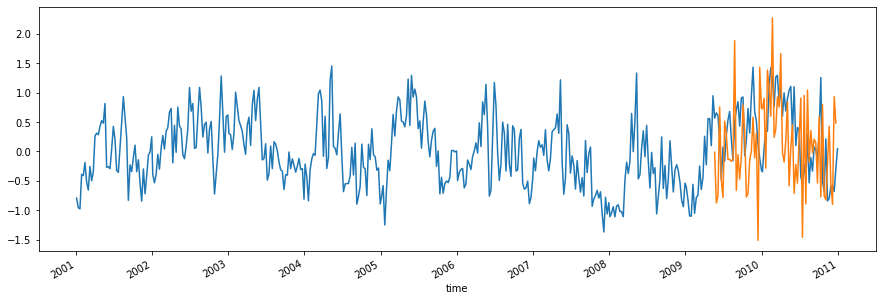

In [33]:
plt.figure(figsize=(15,5))
x_std['air_temperature_2m'].plot()
forecastDf['air_temperature_2m'][5:-1].plot()

Para visualizar las series de tiempo en conjunto vamos a plotear el promedio estandarizado de estas

In [0]:
def fullPlot(timeseries,colors,label_main,win=6):
  #Determing rolling statistics
  rolmean = timeseries.rolling(window=win).mean()
  rolstd = timeseries.rolling(window=win).std()
  #Plot rolling statistics:
  plt.plot(timeseries, color=colors[0],label=label_main)
  #plt.plot(rolmean, color=colors[1], label=label_main+' Rolling Mean')
  #plt.plot(rolstd, color=colors[2], label =label_main+ ' Rolling Std')
  plt.legend(loc='best')
  

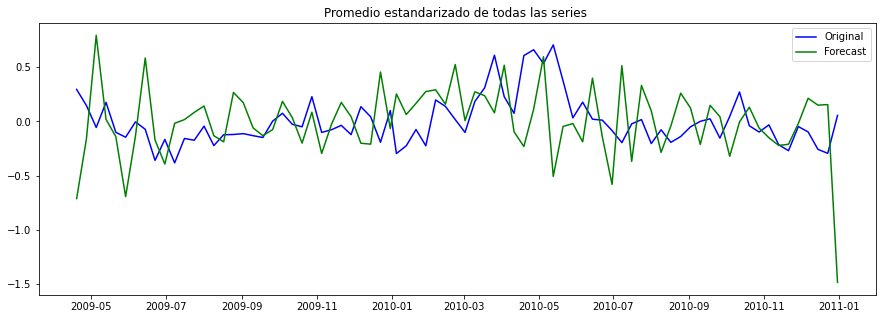

In [35]:
plt.figure(figsize=(15,5))
indx=pd.to_datetime(Fdf_test.index)[1:]


#Real data plot
dataReal=data.loc[indx]
dataReal=StandardScaler().fit_transform(dataReal)
TsReal=pd.Series(np.mean(dataReal,axis=1),index=indx)
colors=['blue','red','black']
plt.subplot(111)
fullPlot(TsReal,colors,'Original')

#Forecasted data plot
dataForecast=forecastDf.loc[indx]
dataForecast=StandardScaler().fit_transform(dataForecast)
TsForecast2=pd.Series(np.mean(dataForecast,axis=1),index=indx)
colors=['green','cyan','purple']
plt.subplot(111)
fullPlot(TsForecast2,colors,'Forecast')

plt.title('Promedio estandarizado de todas las series ')
plt.show()


In [36]:
np.shape(TsForecast)

(80, 29)

## Finalmente calculemos el MSE

In [37]:
indx=pd.to_datetime(list(Fdf_test.index))
scaler_final=StandardScaler()
scaler_final.fit(data.loc[indx])
data_stan=scaler_final.transform(data.loc[indx])
forecast_stan=scaler_final.transform(TsForecast)
mse=mean_squared_error(data_stan,forecast_stan)
mse

1.1688044179082568

# VECM

Volvemos hacer gridsearch sobre los parametros

In [0]:
def VECM_gridsearch(X,y,searchSpace,nobs):
  min_mse=np.inf
  for params in searchSpace:
    model=VECM(X,k_ar_diff=params[0],coint_rank=params[1],deterministic=params[2])
    model_fit = model.fit()
    yhat = model_fit.predict(steps=nobs)
    mse=mean_squared_error(y,yhat)
    if mse<min_mse:
      min_mse=mse
      best_order=params
      best_model=model_fit
    return best_order,min_mse,best_model

In [0]:
#train y test
nobs = 80
Fdf_train, Fdf_test = Fdf[0:-nobs], Fdf[-nobs:]

In [0]:
deterministic=["nc", "co", "ci", "lo", "li"]
k_ar_diffint=list(range(60))
coint_rank=list(range(12))
searchSpace=list(itertools.product(k_ar_diffint,coint_rank,deterministic))

In [41]:
params,mse,vecm_model=VECM_gridsearch(Fdf_train,Fdf_test,searchSpace,nobs)
print('Los mejores parametros para el modelo son: '+str(params)+', con un MSE de: '+str(mse))

Los mejores parametros para el modelo son: (0, 0, 'nc'), con un MSE de: 0.01356568221477905


In [42]:
out = durbin_watson(vecm_model.resid)

def adjust(val, length = 6): return str(val).ljust(length)

for col, val in zip(Fdf.columns, out):
    print(adjust(col), ':', round(val, 2))

component_0 : 2.73
component_1 : 2.89
component_2 : 2.9
component_3 : 2.79
component_4 : 2.69
component_5 : 2.87
component_6 : 2.94
component_7 : 2.85
component_8 : 2.96
component_9 : 2.8
component_10 : 2.86
component_11 : 2.81


Hay componentes con valores un poco alejados de 2, por lo que sería posible mejorar el estimado de los parametros para el modelo.

Proseguimos a realizar el forecast

In [43]:
forecast=vecm_model.predict(steps=nobs)
TsForecast=invTransform(forecast,scaler,transformer,sel,fourierCoef,shape_Kdf)
X_standard=transformer.inverse_transform(Kdf)
X=scaler.inverse_transform(X_standard)
indx=pd.to_datetime(list(Fdf_test.index))
cols=list(data.columns)
forecastDf=pd.DataFrame(TsForecast,index=indx,columns=cols)
forecastDf.head()

,air_temperature_2m,black_sky_albedo,black_sky_albedo_avhrr,cee,cer,cfc,cot,cph,cth,ctp,ctt,fapar_tip,gross_primary_productivity,iwp,latent_energy,leaf_area_index,lwp,max_air_temperature_2m,min_air_temperature_2m,net_ecosystem_exchange,net_radiation,par,precipitation,precipitation_era5,sensible_heat,stemp,terrestrial_ecosystem_respiration,white_sky_albedo,white_sky_albedo_avhrr
2009-04-11,295.026917,0.058578,0.169318,0.783037,17.583814,0.807702,6.562443,0.484287,7.132637,479.470306,259.711365,0.170550,5.396470,106.163035,9.466590,0.467234,47.739585,299.785614,291.089106,-0.911666,12.817318,99.535945,2.100907,0.240486,2.497242,295.684871,4.135857,0.070603,0.177324
2009-04-19,295.015646,0.059734,0.171435,0.785534,17.641504,0.823725,6.382782,0.473066,7.210261,475.377865,259.215446,0.170483,5.374904,97.750426,9.392418,0.493049,46.663328,299.703425,291.194705,-0.902941,12.715433,98.530819,1.766090,0.258527,2.452360,295.665853,4.129919,0.071539,0.179497
2009-04-27,295.002638,0.060255,0.172616,0.787801,17.747227,0.836165,6.315148,0.464829,7.269433,472.200580,258.836205,0.170293,5.360804,95.924164,9.336116,0.505215,46.337541,299.660733,291.251915,-0.899738,12.636716,97.639417,1.926782,0.266246,2.417531,295.640240,4.123646,0.071902,0.180682
2009-05-05,295.038012,0.060071,0.173592,0.788575,17.939204,0.834636,6.471152,0.459461,7.321577,469.232021,258.532179,0.171210,5.399820,103.046194,9.419423,0.503686,47.363413,299.726599,291.223562,-0.909609,12.781976,99.188356,1.892195,0.265542,2.463317,295.683869,4.142239,0.072138,0.181793
2009-05-13,295.023649,0.059699,0.171986,0.786301,17.726399,0.825958,6.457975,0.470118,7.233675,473.990019,259.078277,0.169221,5.389913,101.044666,9.422926,0.486296,47.274514,299.719010,291.182872,-0.907671,12.766565,98.983782,1.868218,0.257805,2.465491,295.675982,4.135442,0.071639,0.180172


In [0]:
forecastDf_scal=StandardScaler().fit_transform(forecastDf)
forecastDf=pd.DataFrame(forecastDf_scal,index=indx,columns=cols)
x_std=pd.DataFrame(X_standard,index=data.index,columns=cols)


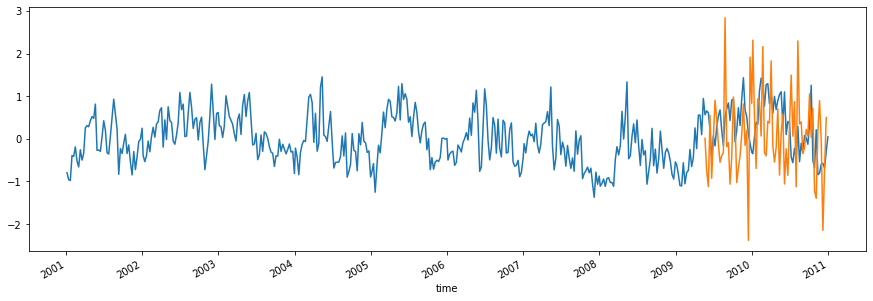

In [45]:
plt.figure(figsize=(15,5))
x_std['air_temperature_2m'].plot()
forecastDf['air_temperature_2m'][5:-1].plot()

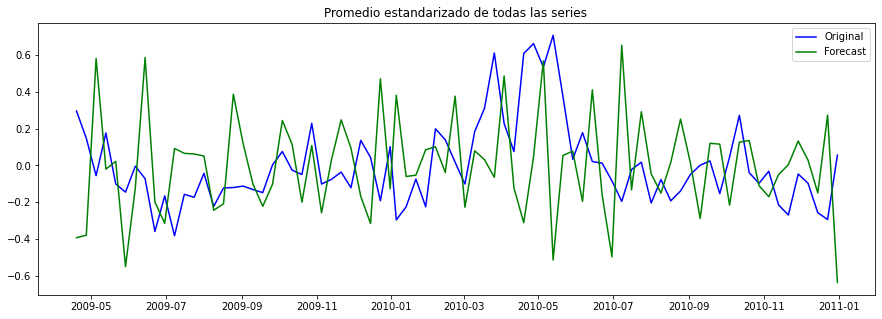

In [46]:
plt.figure(figsize=(15,5))
indx=pd.to_datetime(Fdf_test.index)[1:]


#Real data plot
dataReal=data.loc[indx]
dataReal=StandardScaler().fit_transform(dataReal)
TsReal=pd.Series(np.mean(dataReal,axis=1),index=indx)
colors=['blue','red','black']
plt.subplot(111)
fullPlot(TsReal,colors,'Original')

#Forecasted data plot
dataForecast=forecastDf.loc[indx]
dataForecast=StandardScaler().fit_transform(dataForecast)
TsForecast2=pd.Series(np.mean(dataForecast,axis=1),index=indx)
colors=['green','cyan','purple']
plt.subplot(111)
fullPlot(TsForecast2,colors,'Forecast')

plt.title('Promedio estandarizado de todas las series ')
plt.show()


## Finalmente calculemos el MSE

In [47]:
indx=pd.to_datetime(list(Fdf_test.index))
scaler_final=StandardScaler()
scaler_final.fit(data.loc[indx])
data_stan=scaler_final.transform(data.loc[indx])
forecast_stan=scaler_final.transform(TsForecast)
mse=mean_squared_error(data_stan,forecast_stan)
mse

1.2008807005425255

# VARMAX=1.1688044179082568 | VECM=1.2008807005425255